## Libraries

In [1]:
import re 
import spacy
import pandas as pd 
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords

## Preprocessing

**Import the data set**

In [2]:
file = 'Data/discrimination.csv'
discrimination = pd.read_csv(file, sep=",")

In [3]:
# Preview 
discrimination.head()

,Tweets,MultiClass_Labels,Labels
0,@TVBachelor @NewJerzeyBoy what about the femin...,1,1
1,@ThelmaSleaze uh... did you watch the video? o...,1,1
2,Managed to hit a bird and a small rodent on my...,1,1
3,"If you believe a #holohoax or #gays, LGBT &amp...",1,1
4,"Rid yourself of #Feminazi, #Fag &amp; #Jewf. E...",1,1


**Labels (Multiclass)**

In [4]:
discrimination['MultiClass_Labels'].value_counts()

0    16844
2     3998
1     2062
Name: MultiClass_Labels, dtype: int64

**Labels (Bi-Class)**

In [5]:
discrimination['Labels'].value_counts()

0    16844
1     6060
Name: Labels, dtype: int64

**Number of #tags**

<AxesSubplot:xlabel='0'>

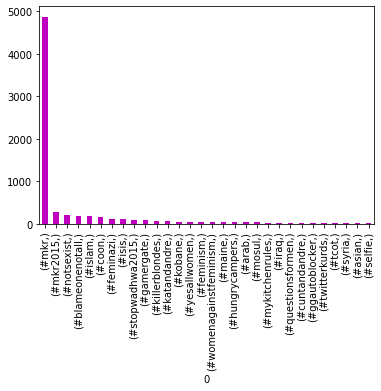

In [16]:
# all tweets in one string 
corpus = ' '.join(discrimination['Tweets'])

# find #words 
r = re.compile(r"#\w+")
items = r.findall(corpus.lower())
items = pd.DataFrame(items)

# show 
items.value_counts()[items.value_counts() > 20].plot(kind="bar", color='m')

**Clean & Split Data**

In [6]:
from DPreprocessing import data_cleaning
X = data_cleaning(discrimination['Tweets'])
y = discrimination['Labels']

>>>>>> Data Cleaning Process : Start
>>> Normalization | Remove ids @ | Replace urls by URL tag | Remove Special char | Remove Punctuation 


**Word Cloud**

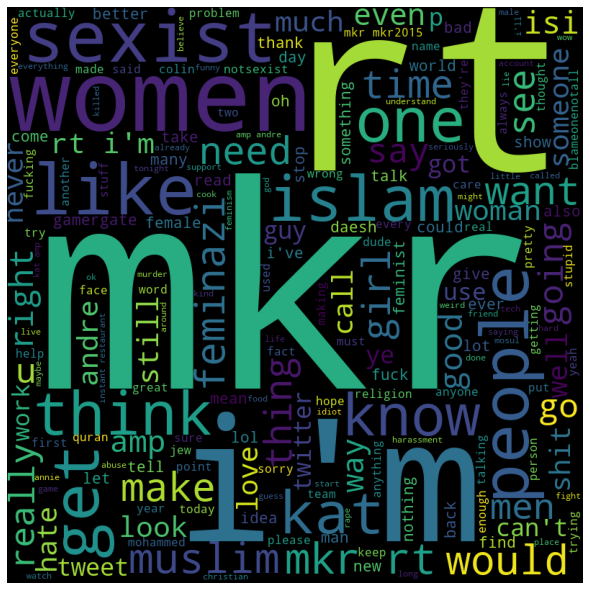

In [22]:
# all cleaned tweets in on string 
racism_corpus = ' '.join(X)

# list of stop words 
stopwords = stopwords.words('english')

# generate word cloud 
from wordcloud import WordCloud 
model = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10)
wordcloud = model.generate(racism_corpus) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

**Lemmatization**

In [7]:
%%time 
from DPreprocessing import canonization
X_lem = canonization(X, method="lemmatization")

CPU times: user 2min 21s, sys: 871 ms, total: 2min 22s
Wall time: 2min 24s


**Tfidf**

In [9]:
%%time 
from Vectorizer import tfidf
X_lem_tfidf = tfidf(X_lem, nbr_tokens=1000, ngram=1)

CPU times: user 383 ms, sys: 76.3 ms, total: 459 ms
Wall time: 496 ms


**Feature Engineering**

Evaluation : SVM (baseline model) 

In [8]:
def evaluation(X):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

    from sklearn.svm import SVC 
    model = SVC(kernel='linear', random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    from sklearn.metrics import accuracy_score, f1_score
    f1_score = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return f1_score, accuracy

Without new features 

In [69]:
f1score_m0, accuracy_m0 = evaluation(X_lem_tfidf)

Polarity 

In [10]:
from FeatureEngineering import polarity
polarity_ = polarity(X)

In [65]:
# Polarity 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), polarity_], axis=1)
f1score_m1, accuracy_m1 = evaluation(newX)

Length 

In [11]:
from FeatureEngineering import len_tweets
length = len_tweets(X_lem)

In [64]:
# Length 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), length], axis=1)
f1score_m2, accuracy_m2 = evaluation(newX)discrimination

Subjectivity 


In [12]:
from FeatureEngineering import subjectivity
subjectivity_ = subjectivity(X)

In [63]:
# Subjectivity 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), subjectivity_], axis=1)
f1score_m3, accuracy_m3 = evaluation(newX)   

NER features 

In [13]:
def named_entity_recognition(tweets):
    import spacy
    nlp = spacy.load('en_core_web_sm')
    bloc = []
    for tweet in tweets: 
        doc = nlp(tweet)
        for ent in doc.ents:
            bloc.append([ent.text, ent.label_])
    return pd.DataFrame(bloc,columns=['Text','Label'])

In [14]:
%%time
from FeatureEngineering import newfeatures #named_entity_recognition, newfeatures
from DPreprocessing import data_cleaning 
ner = named_entity_recognition(X_lem)
ner_categories = ner['Label'].value_counts()[ner['Label'].value_counts() > 1000].index.tolist()

ner_features_index = []
for category in ner_categories :
    #NER[NER['Label']==category].value_counts()[:30].plot(kind='bar', color=colors_list)
    #plt.show()
    condition = ner['Text'][ner['Label']==category].value_counts()>50
    element = ner['Text'][ner['Label']==category].value_counts()[condition].index.tolist()
    ner_features_index.extend(element)

ner_features = newfeatures(ner_features_index, X_lem) 

CPU times: user 2min 15s, sys: 626 ms, total: 2min 16s
Wall time: 2min 17s


In [62]:
# NER features 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), ner_features], axis=1)
f1score_m4, accuracy_m4 = evaluation(newX)

UniGram 

In [15]:
from FeatureEngineering import ngram, ngrams_frequency
# Unigram 
unigram = ngram(X_lem, nbr_gram=1, stopwords='english')
unigram = ngrams_frequency(X_lem, unigram)
unigram_100 = unigram['Gram'][:100]
unigram_features = newfeatures(unigram_100, X_lem)

<AxesSubplot:xlabel='Gram'>

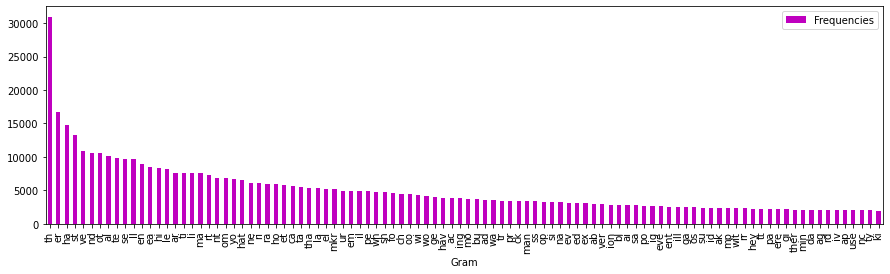

In [51]:
unigram[:100].plot(x='Gram', y='Frequencies', kind='bar', color='m', figsize=(15,4))

In [61]:
# Unigram 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), unigram_features], axis=1)
f1score_m5, accuracy_m5 = evaluation(newX)

BiGram 

In [16]:
from FeatureEngineering import ngram, ngrams_frequency
# Bigram 
bigram = ngram(X_lem, nbr_gram=2, stopwords='english')
bigram = ngrams_frequency(X_lem, bigram)
bigram_100 = bigram['Gram'][:100]
bigram_features = newfeatures(bigram_100, X_lem)

<AxesSubplot:xlabel='Gram'>

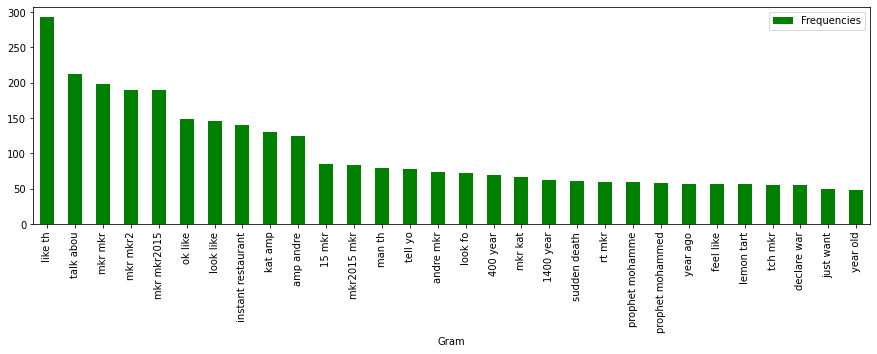

In [53]:
bigram[:30].plot(x='Gram', y='Frequencies', kind='bar', color='g', figsize=(15,4))

In [60]:
# Bigram 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), bigram_features], axis=1)
f1score_m6, accuracy_m6 = evaluation(newX)

TriGram 

In [17]:
from FeatureEngineering import ngram, ngrams_frequency
# Trigram 
trigram = ngram(X_lem, nbr_gram=3, stopwords='english')
trigram = ngrams_frequency(X_lem, trigram)
trigram_100 = trigram['Gram'][:100]
trigram_features = newfeatures(trigram_100, X_lem)

<AxesSubplot:xlabel='Gram'>

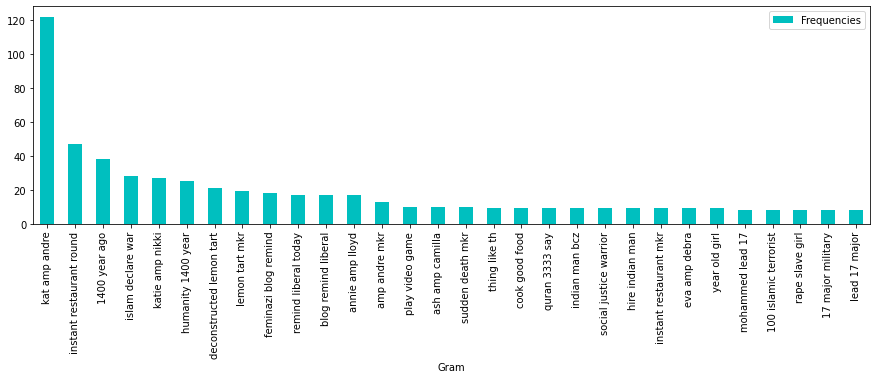

In [56]:
trigram[:30].plot(x='Gram', y='Frequencies', kind='bar', color='c', figsize=(15,4))

In [59]:
# Trigram 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), trigram_features], axis=1)
f1score_m7, accuracy_m7 = evaluation(newX)

Shallow Parsing 

Dependency parcing 

In [20]:
from tqdm import tqdm
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from FeatureEngineering import dependency_graph

tweet_dependencies = dependency_graph(X_lem)

tf_idf = TfidfVectorizer(binary=True,smooth_idf=False,)
tweet_dependency_features = tf_idf.fit_transform(np.array(tweet_dependencies)).toarray()
tweet_dependency_features = pd.DataFrame(tweet_dependency_features)

In [58]:
# Dependency Parsing 
newX = pd.concat([pd.DataFrame(X_lem_tfidf), tweet_dependency_features], axis=1)
f1score_m9, accuracy_m9 = evaluation(newX)

**Comparison**

In [183]:
m0 = ["Without",accuracy_m0,f1score_m0] 
m1 = ["Polarity",accuracy_m1,f1score_m1]
m2 = ["Length",accuracy_m2,f1score_m2]
m3 = ["Subjectivity",accuracy_m3,f1score_m3]
m4 = ["NER",accuracy_m4,f1score_m4]
m5 = ["Unigram",accuracy_m5,f1score_m5]
m6 = ["Bigram",accuracy_m6,f1score_m6]
m7 = ["Trigram",accuracy_m7,f1score_m7]
#m8 = ["Polarity",accuracy_m8,f1score_m8]
m9 = ["Dependency Parsing",accuracy_m9,f1score_m9]

In [56]:
def results(*args):
    '''
   len_tweetsMethod,Accuracy,F1Score]
    '''
    
    methods_results = []
    for method in args:
        methods_results.append(method)
    return pd.DataFrame(methods_results,columns=["Methods","Accuracy","F1 Score"])

In [185]:
results(m0,m1,m2,m3,m4,m5,m6,m7,m9)

,Methods,Accuracy,F1 Score
0,Without,0.849534,0.674023
1,Polarity,0.849389,0.673810
2,Length,0.848370,0.672944
3,Subjectivity,0.849389,0.673810
4,NER,0.851281,0.677603
5,Unigram,0.848807,0.677429
6,Bigram,0.848079,0.672727
7,Trigram,0.850990,0.676972
8,Dependency Parsing,0.848661,0.673572


## Modeling 

**BiClass Classification**

Features 

In [21]:
def combine_features(X, *new_features):
    X = pd.DataFrame(X)
    F = pd.concat(list(new_features), axis=1)
    return pd.concat([F,X], axis=1)

In [52]:
Features = combine_features(X_lem_tfidf, length, subjectivity_, ner_features, trigram_features, tweet_dependency_features)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, y, test_size=0.30, random_state=42, shuffle=True)

Support Vector Machine 

In [54]:
%%time
#f1_score_svm, accuracy_score_svm = evaluation(Features)
# Training & Evaluation 
from sklearn.svm import SVC 
model = SVC(kernel='linear', random_state=0)
model.fit(X_train, y_train)

# prediction 
y_pred = model.predict(X_test)

# evaluation 
from sklearn.metrics import accuracy_score, f1_score
f1_score_svm = f1_score(y_test, y_pred)
accuracy_svm = accuracy_score(y_test, y_pred)

CPU times: user 9min 32s, sys: 947 ms, total: 9min 33s
Wall time: 9min 34s


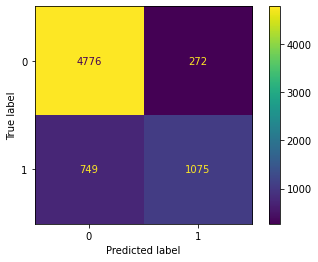

In [191]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

Logistic Regression

In [59]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# evaluation 
from sklearn.metrics import accuracy_score, f1_score
f1_score_logreg = f1_score(y_test, y_pred)
accuracy_logreg = accuracy_score(y_test, y_pred)

CPU times: user 7.37 s, sys: 456 ms, total: 7.83 s
Wall time: 2.34 s


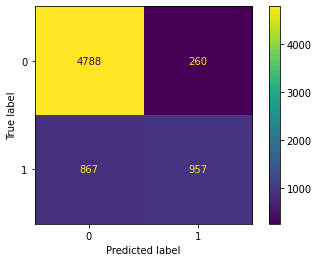

In [193]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

Random Forest 

In [60]:
# training 
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# prediction 
y_pred = model.predict(X_test)

# evaluation 
from sklearn.metrics import accuracy_score, f1_score
f1_score_rf = f1_score(y_test, y_pred)
accuracy_rf = accuracy_score(y_test, y_pred)

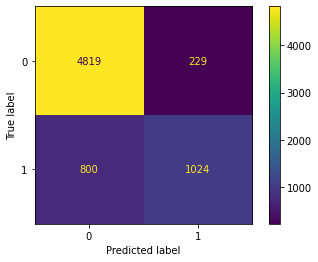

In [195]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

**MultiClass Classification**

In [67]:
Features = combine_features(X_lem_tfidf, length, subjectivity_, ner_features, trigram_features, tweet_dependency_features)
y_multi = discrimination['MultiClass_Labels']

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, y_multi, test_size=0.30, random_state=42, shuffle=True)

Support Vector Machine 

In [ ]:
%%time
#f1_score_svm, accuracy_score_svm = evaluation(Features)
# Training & Evaluation 
from sklearn.svm import SVC 
model = SVC(kernel='linear', random_state=0)
model.fit(X_train, y_train)

# prediction 
y_pred = model.predict(X_test)

# evaluation 
from sklearn.metrics import accuracy_score, f1_score
f1_score_svm_multi = f1_score(y_test, y_pred, average='micro')
accuracy_svm_multi = accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

Logistic Regression 

In [71]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# evaluation 
from sklearn.metrics import accuracy_score, f1_score
f1_score_logreg_multi = f1_score(y_test, y_pred, average='micro')
accuracy_logreg_multi = accuracy_score(y_test, y_pred)

CPU times: user 18.7 s, sys: 671 ms, total: 19.4 s
Wall time: 5.21 s


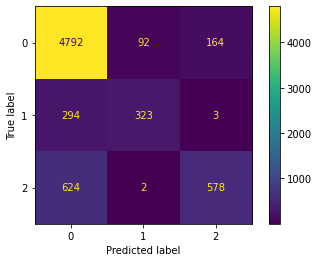

In [72]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

Random Forest 

In [69]:
# training 
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# prediction 
y_pred = model.predict(X_test)

# evaluation 
from sklearn.metrics import accuracy_score, f1_score
f1_score_rf_multi = f1_score(y_test, y_pred, average='micro')
accuracy_rf_multi = accuracy_score(y_test, y_pred)

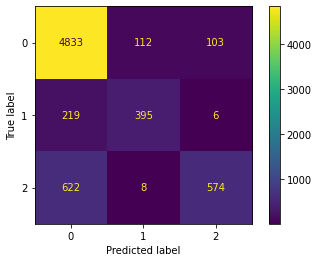

In [70]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

**Results**

In [58]:
m0 = ["BiClass SVM",accuracy_svm,f1_score_svm] 
m1 = ["MultiClass SVM",accuracy_svm_multi,f1_score_svm_multi]
results(m0,m1)

,Methods,Accuracy,F1 Score
0,BiClass SVM,0.851426,0.678020
1,MultiClass SVM,0.850407,0.850407


In [61]:
m0 = ["BiClass LogReg",accuracy_logreg,f1_score_logreg] 
m1 = ["MultiClass LogReg",accuracy_logreg_multi,f1_score_logreg_multi]
results(m0,m1)

,Methods,Accuracy,F1 Score
0,BiClass LogReg,0.836001,0.629398
1,MultiClass LogReg,0.828434,0.828434


In [66]:
m0 = ["BiClass Random Forest",accuracy_rf,f1_score_rf] 
m1 = ["MultiClass Random Forest",accuracy_rf_multi,f1_score_rf_multi]
results(m0,m1)

,Methods,Accuracy,F1 Score
0,BiClass Random Forest,0.850262,0.665583
1,MultiClass Random Forest,0.844296,0.844296
